In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [3]:
from utils_model_sampling import sample_models_across_time
from utils import load_models
from utils_model_sampling import hyperparameter_utils

In [4]:
import configuration
config = configuration.Config()

# Load Scores and move to R

In [9]:
from utils_model_sampling import hyperparameter_utils
import imp
imp.reload(hyperparameter_utils)

<module 'utils_model_sampling.hyperparameter_utils' from '/home/stephan/notebooks/nicole/child-directed-listening/utils_model_sampling/hyperparameter_utils.py'>

In [10]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

In [11]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

In [12]:
raw_scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

In [13]:
all_args = load_models.gen_all_model_args()

beta_set = {}
lambda_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'beta')
    beta_set[model_title] = round(this_beta, 3)
    this_lambda = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'lambda')
    lambda_set[model_title] = round(this_lambda, 3)
    
pprint(beta_set)
pprint(lambda_set)

{'Adult BERT without tags, , +-20 utts context': 3.5,
 'Adult BERT without tags, , same utt only': 4.2,
 'CHILDES BERT with tags, , +-20 utts context': 3.1,
 'CHILDES BERT with tags, , same utt only': 3.2,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.5,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.2,
 'CHILDES BERT without tags, , same utt only': 3.3,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.5,
 'CHILDES BERT without tags, older children, same utt only': 3.6,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.2,
 'CHILDES BERT without tags, younger children, same utt only': 3.2,
 'CHILDES unigram without tags, , same utt only': 3.5,
 'Flat prior without tags, , same utt only': 3.7}
{'Adult BERT without tags, , +-20 utts co

In [14]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}

tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


In [276]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

In [277]:
%%R
# rename the models

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)
successes_across_time = subset(scores_across_time_short, set == 'success')

In [18]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

In [20]:
%%R
overview_set = c(
    'CDL+Context+Tags',
    'BERT+Context',
    'CDL+OneUtt+Tags',
    'BERT+OneUtt',
    'CHILDES 1gram',
    'UniformPrior')

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

# Verify Sample Size

In [299]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(successes_and_failures_per_time$bert_token_id))

       set age bert_token_id
1  failure 1.0          1521
2  success 1.0          2412
3  failure 1.5          1890
4  success 1.5          5499
5  failure 2.0          1412
6  success 2.0         10877
7  failure 2.5          1149
8  success 2.5         13980
9  failure 3.0           699
10 success 3.0          8517
11 failure 3.5            85
12 success 3.5          2708
[1] 50749


# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [350]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 1407776  216192


In [351]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "UniformPrior"             "CHILDES 1gram"           


## Levenshtein Distance

In [352]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(scores_across_time_short, auc_by_model)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

In [353]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

In [354]:
%%R
as.character(scores_across_time_short_lev$model)[0:10]

 [1] "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context"
 [6] "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context" "BERT+Context"


In [355]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model, scores_across_time_short_lev, unique)
scores_per_model = aggregate(auc_levdist ~ model, scores_across_time_short_lev, unique)
scores_per_model = merge(names_per_model, scores_per_model)
scores_per_model = scores_per_model[order(scores_per_model$auc_levdist, decreasing=T),]
print(scores_per_model)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model$model_with_levdist_auc))

                      model                 model_with_levdist_auc auc_levdist
6    CDL+Older+Context+Tags    CDL+Older+Context+Tags (AUC = 0.87)   0.8700051
5         CDL+Older+Context         CDL+Older+Context (AUC = 0.87)   0.8697567
4          CDL+Context+Tags         CDL+Context+Tags (AUC = 0.869)   0.8688781
3               CDL+Context              CDL+Context (AUC = 0.866)   0.8659712
11      CDL+Younger+Context      CDL+Younger+Context (AUC = 0.861)   0.8605072
1              BERT+Context             BERT+Context (AUC = 0.858)   0.8575619
12 CDL+Younger+Context+Tags CDL+Younger+Context+Tags (AUC = 0.857)   0.8566563
9                CDL+OneUtt               CDL+OneUtt (AUC = 0.835)   0.8347959
7          CDL+Older+OneUtt         CDL+Older+OneUtt (AUC = 0.834)   0.8337872
10          CDL+OneUtt+Tags          CDL+OneUtt+Tags (AUC = 0.831)   0.8314599
8     CDL+Older+OneUtt+Tags    CDL+Older+OneUtt+Tags (AUC = 0.829)   0.8290586
13       CDL+Younger+OneUtt       CDL+Younger+OneUtt

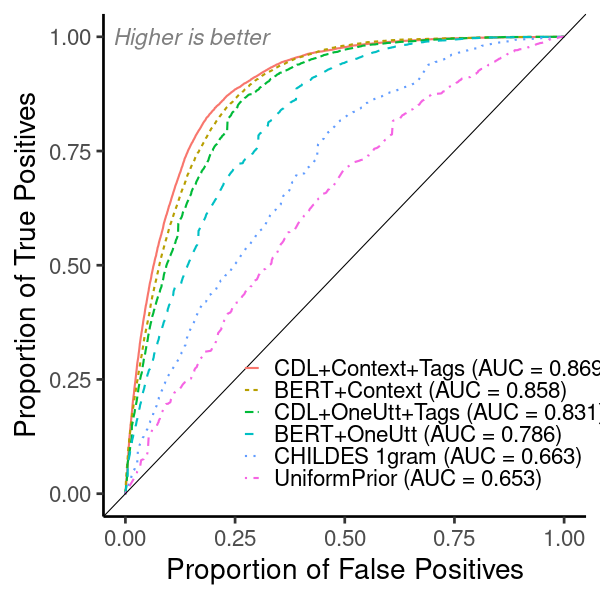

In [356]:
%%R -h 600 -w 600
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_levdist_auc, linetype = model_with_levdist_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
ggsave('figures/roc_levdist.pdf', height=12, width=12)    
print(p1)

## WFST

In [414]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(scores_across_time_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

In [410]:
# !!! fix this so that it isn't saying tags

In [424]:
%%R

# get rid of tags in the designation
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
scores_across_time_overview_set$model_shortname = gsub('\\+Tags','', scores_across_time_overview_set$model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

In [497]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model = merge(names_per_model, scores_per_model)
scores_per_model = scores_per_model[order(scores_per_model$auc_wfst, decreasing=T),]
print(scores_per_model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model$model_shortname_with_wfst_auc))

  model_shortname model_shortname_with_wfst_auc  auc_wfst
3     CDL+Context     CDL+Context (AUC = 0.915) 0.9154559
1    BERT+Context    BERT+Context (AUC = 0.903) 0.9025264
4      CDL+OneUtt      CDL+OneUtt (AUC = 0.894) 0.8940127
2     BERT+OneUtt     BERT+OneUtt (AUC = 0.846) 0.8456843
5   CHILDES 1gram   CHILDES 1gram (AUC = 0.755) 0.7554012
6    UniformPrior    UniformPrior (AUC = 0.628) 0.6275376


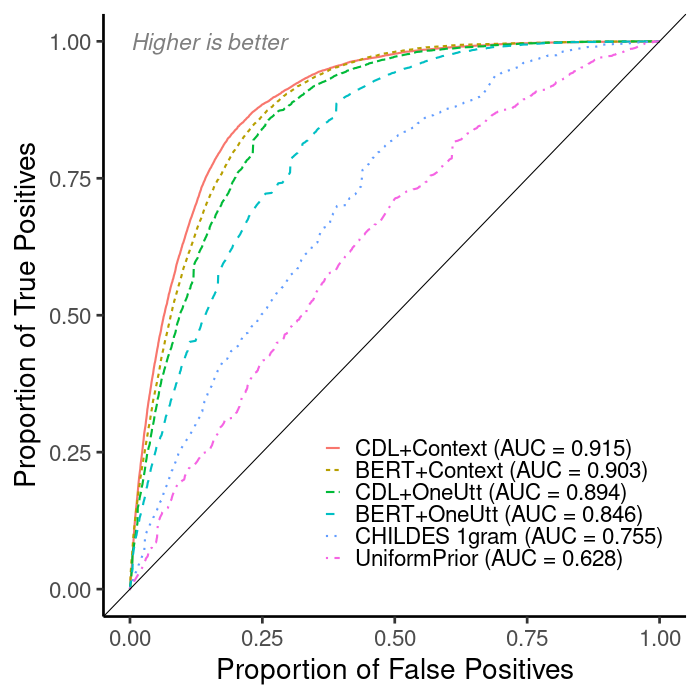

In [498]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc, linetype = model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_likelihoods.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [499]:
%%R
g <- ggplot_build(p1)
colors_for_6_plots = unique(g$data[[1]]$colour)
colors_for_6_plots

[1] "#F8766D" "#B79F00" "#00BA38" "#00BFC4" "#619CFF" "#F564E3"


In [502]:
%%R
models_for_6_plots = scores_per_model$model_shortname
as.character(models_for_6_plots)

[1] "CDL+Context"   "BERT+Context"  "CDL+OneUtt"    "BERT+OneUtt"  
[5] "CHILDES 1gram" "UniformPrior" 


## Visualization of Exemplars

In [ ]:
%%R
unique(as.character(scores_across_time_short$model))

In [ ]:
%%R
names(scores_across_time_short)

In [ ]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "CDL+Context+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

In [ ]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

# Analysis 2: Do the models find the same words as adults?

## Priors

In [361]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                


### Prior Table

#### WFST

In [338]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})


prior_probs = merge(prior_probs, posterior_probs)
    
prior_probs = prior_probs[order(prior_probs$prior_probability),]
subset(prior_probs, model %in% overview_set)

              model prior_probability posterior_probability
4  CDL+Context+Tags          3.324232             0.6445381
1      BERT+Context          4.620647             1.0644111
10  CDL+OneUtt+Tags          5.071030             1.0944034
2       BERT+OneUtt          7.338912             1.8815163
15    CHILDES 1gram          8.786068             2.2773164
16     UniformPrior         12.965243             4.6082285


In [339]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'mean_prior_rank')

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model'))
rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

              model mean_prior_rank mean_posterior_rank
4  CDL+Context+Tags         50.4358            2.476394
10  CDL+OneUtt+Tags        125.1256            6.911941
1      BERT+Context        140.7688            6.176187
15    CHILDES 1gram        313.7241           14.542632
2       BERT+OneUtt        495.1434           17.875139
16     UniformPrior       3998.0000           62.402769


In [340]:
%%R
for_table = subset(merge(prior_probs, rankings, all.x=T), model %in% overview_set)
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
for_table = for_table[,c('model','prior_probability','mean_prior_rank','posterior_probability','mean_posterior_rank')]
for_table =  for_table[order(for_table$prior_probability),]
names(for_table) = c('Model', 'Prior Surprisal (bits)', 'Mean Prior Rank', 'Posterior Surprisal (bits)', 'Mean Posterior Rank')
for_table

              Model Prior Surprisal (bits) Mean Prior Rank
4  CDL+Context+Tags                   3.32           50.44
1      BERT+Context                   4.62          140.77
10  CDL+OneUtt+Tags                   5.07          125.13
2       BERT+OneUtt                   7.34          495.14
15    CHILDES 1gram                   8.79          313.72
16     UniformPrior                  12.97         3998.00
   Posterior Surprisal (bits) Mean Posterior Rank
4                        0.64                2.48
1                        1.06                6.18
10                       1.09                6.91
2                        1.88               17.88
15                       2.28               14.54
16                       4.61               62.40


In [341]:
%%R
write.csv(for_table, 'csv/surprisal_table.csv', row.names=F)

#### Levenshtein Distance

In [345]:
%%R
prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})


prior_probs = merge(prior_probs, posterior_probs)
    
prior_probs = prior_probs[order(prior_probs$prior_probability),]
subset(prior_probs, model %in% overview_set)

              model prior_probability posterior_probability
4  CDL+Context+Tags          3.324232              1.180780
1      BERT+Context          4.620647              1.719009
10  CDL+OneUtt+Tags          5.071030              1.954397
2       BERT+OneUtt          7.338912              2.884170
15    CHILDES 1gram          8.786068              3.841817
16     UniformPrior         12.965243              5.059256


In [342]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'mean_prior_rank')

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model'))
rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

              model mean_prior_rank mean_posterior_rank
4  CDL+Context+Tags         50.4358            8.084968
10  CDL+OneUtt+Tags        125.1256           25.098266
1      BERT+Context        140.7688           19.104630
15    CHILDES 1gram        313.7241           51.082354
2       BERT+OneUtt        495.1434           48.140045
16     UniformPrior       3998.0000          145.844816


In [52]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type CDL+Context+Tags  CDL+Context CDL+OneUtt+Tags
2          10577            WFST     4.322200e-07 8.217112e-07    7.774114e-05
4          39428            WFST     7.276610e-04 5.362953e-04    2.820361e-03
6          39594            WFST     7.019745e-01 4.591151e-01    2.820361e-03
8          41265            WFST     6.389431e-01 7.640047e-01    1.837760e-01
10         41266            WFST     4.115210e-01 2.300410e-01    7.739497e-03
12         41756            WFST     3.451860e-04 3.996108e-06    1.055959e-03
     CDL+OneUtt BERT+Context  BERT+OneUtt CDL+Older+Context+Tags
2  0.0001452172 3.667992e-06 6.627159e-05           9.320406e-06
4  0.0020841388 2.478826e-04 1.482733e-04           5.124065e-04
6  0.0020841388 1.482284e-02 1.482733e-04           8.194972e-01
8  0.0415440015 7.339016e-01 2.187229e-02           5.909310e-01
10 0.0043933694 3.372385e-01 3.032029e-04           4.209669e-02
12 0.0003050996 6.015850e-06 3.048955e-06           2.186

In [71]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
[1] "CDL+Context+Tags" "BERT+Context"     "CDL+OneUtt+Tags"  "BERT+OneUtt"     
[5] "CHILDES 1gram"    "UniformPrior"    
[1] 43993    18


In [72]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"


### t-test Model Comparison

In [73]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                 CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
CDL+Context+Tags               NA            0               0           0
BERT+Context                    0           NA               0           0
CDL+OneUtt+Tags                 0            0              NA           0
BERT+OneUtt                     0            0               0          NA
CHILDES 1gram                   0            0               0           0
UniformPrior                    0            0               0           0
                 CHILDES 1gram UniformPrior
CDL+Context+Tags             0            0
BERT+Context                 0            0
CDL+OneUtt+Tags              0            0
BERT+OneUtt                  0            0
CHILDES 1gram               NA            0
UniformPrior                 0           NA


### Prior Surprisal Across Ages Plots

In [61]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

In [79]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,7.274761,0.115150
2,1.0,BERT+Context,WFST,7.274761,0.115150
3,1.0,BERT+OneUtt,Levenshtein Distance,11.540592,0.109994
4,1.0,BERT+OneUtt,WFST,11.540592,0.109994
5,1.0,CDL+Context,Levenshtein Distance,4.130148,0.109045
...,...,...,...,...,...
188,3.5,CDL+Younger+OneUtt+Tags,WFST,4.558027,0.085502
189,3.5,CHILDES 1gram,Levenshtein Distance,8.952549,0.069915
190,3.5,CHILDES 1gram,WFST,8.952549,0.069915
191,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000


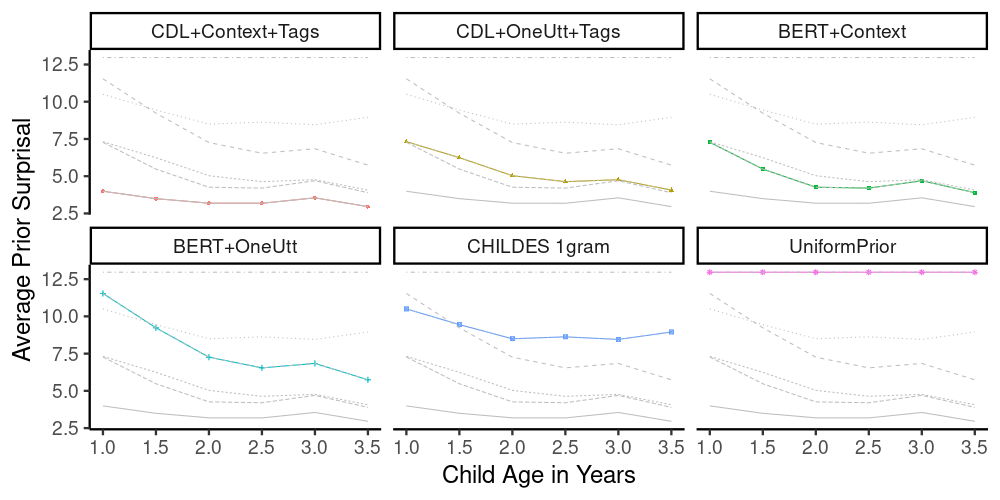

In [80]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

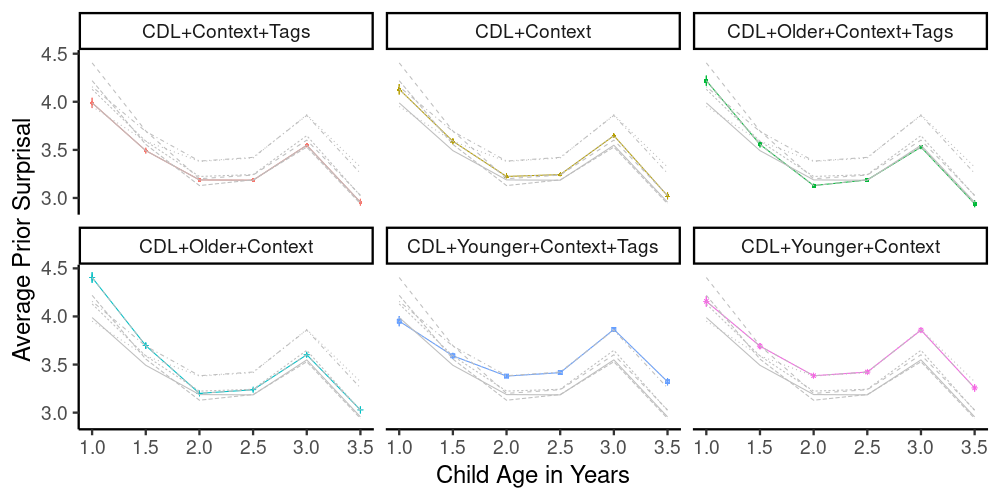

In [81]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [82]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,4.345178,0.114305
2,1.0,BERT+Context,WFST,2.791355,0.089477
3,1.0,BERT+OneUtt,Levenshtein Distance,7.309036,0.149313
4,1.0,BERT+OneUtt,WFST,5.122672,0.124067
5,1.0,CDL+Context,Levenshtein Distance,2.359120,0.089852
...,...,...,...,...,...
188,3.5,CDL+Younger+OneUtt+Tags,WFST,0.712742,0.039535
189,3.5,CHILDES 1gram,Levenshtein Distance,3.062582,0.085565
190,3.5,CHILDES 1gram,WFST,1.958813,0.064519
191,3.5,UniformPrior,Levenshtein Distance,3.800962,0.072356


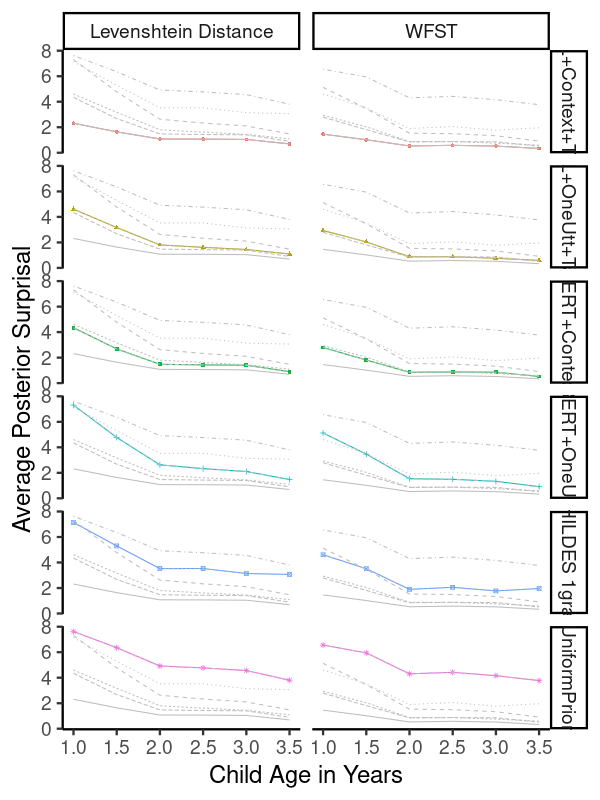

In [83]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [ ]:
#!!! need more specific comparisons:
# older vs. younger (BERT+CONTEXT)
# Levdist (BERT+CONTEXT)

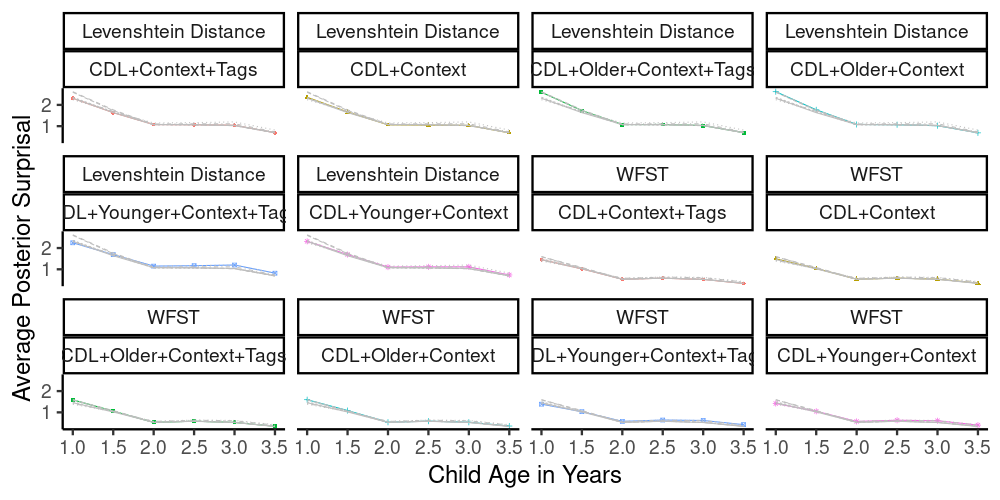

In [84]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [248]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+Context"             "BERT+OneUtt"             
 [3] "CDL+Context"              "CDL+Context+Tags"        
 [5] "CDL+Older+Context"        "CDL+Older+Context+Tags"  
 [7] "CDL+Older+OneUtt"         "CDL+Older+OneUtt+Tags"   
 [9] "CDL+OneUtt"               "CDL+OneUtt+Tags"         
[11] "CDL+Younger+Context"      "CDL+Younger+Context+Tags"
[13] "CDL+Younger+OneUtt"       "CDL+Younger+OneUtt+Tags" 
[15] "CHILDES 1gram"            "UniformPrior"            


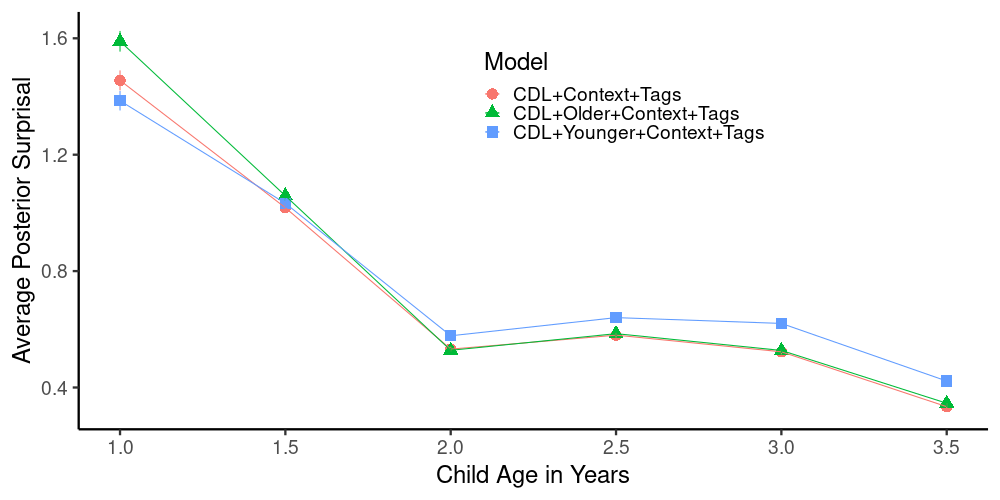

In [266]:
%%R -w 1000 -h 500

selected_models = c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags', 'CDL+Context+Tags')

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    ) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model), size=5) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model"))

ggsave('figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1

In [85]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    43993
failure     6756
Name: set, dtype: int64

### Posterior Probability by Edit Distance Plot

In [88]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 263958     14


In [90]:
%%R
unique(as.character(levdists$model))

[1] "BERT+OneUtt"      "BERT+Context"     "CDL+OneUtt+Tags"  "CDL+Context+Tags"
[5] "UniformPrior"     "CHILDES 1gram"   


In [91]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

In [92]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 263958     14
[1] 263958     15


In [93]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

In [94]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

     bert_token_id edit_distance
1891       1776009             3
1892       1029904             2
1893       1029905             2
1894        506615             1
1895        506616             2
1896        506620             1
1897        506621             0
1898        940389             0
1899        940390             0
1900        855679             3


In [95]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

In [96]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 3 0 1 2 5 4 6 7 8


In [485]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem


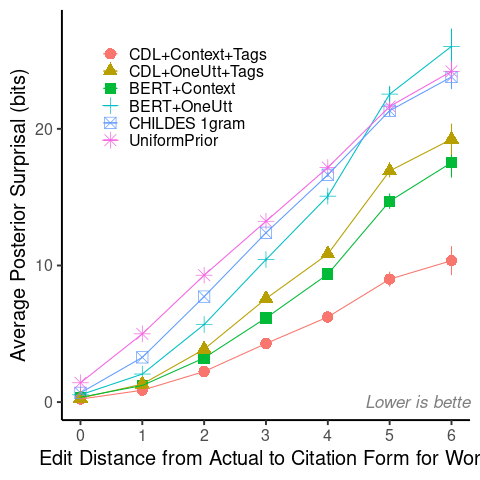

In [464]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type != 'WFST' & edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6))

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

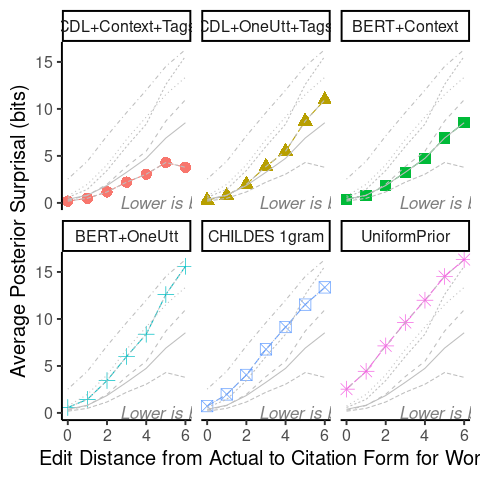

In [100]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance

In [101]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance            model      likelihood_type mean_posterior_surprisal
1              0     BERT+Context Levenshtein Distance                0.3562090
2              0      BERT+OneUtt Levenshtein Distance                0.5353647
3              0 CDL+Context+Tags Levenshtein Distance                0.2232827
4              0  CDL+OneUtt+Tags Levenshtein Distance                0.2926105
5              0    CHILDES 1gram Levenshtein Distance                0.6774828
6              0     UniformPrior Levenshtein Distance                1.4167799
7              1     BERT+Context Levenshtein Distance                1.2194031
8              1      BERT+OneUtt Levenshtein Distance                2.0544969
9              1 CDL+Context+Tags Levenshtein Distance                0.8723959
10             1  CDL+OneUtt+Tags Levenshtein Distance                1.3196422
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.008921241 0.3562090 0.35620

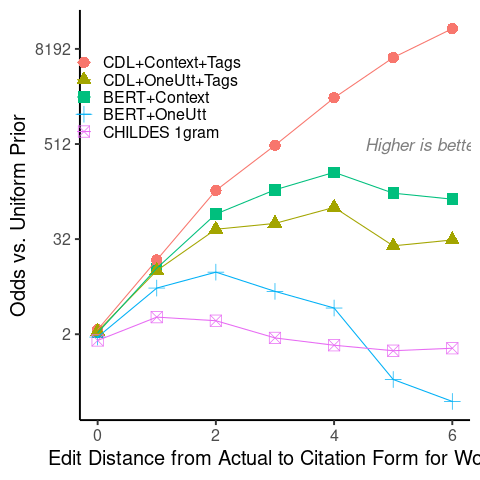

In [463]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_all.pdf', height=6, width=8)    
print(p2)

In [ ]:
# Why did the pattern above change? This is the Levenshtein distance so it should look approximately the same

#### WFST

In [512]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_6_plots)



In [513]:
%%R
as.character(surprisal_by_edit_distance_for_plot$model_shortname)

 [1] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
 [5] "CHILDES 1gram" "UniformPrior"  "BERT+Context"  "BERT+OneUtt"  
 [9] "CDL+Context"   "CDL+OneUtt"    "CHILDES 1gram" "UniformPrior" 
[13] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
[17] "CHILDES 1gram" "UniformPrior"  "BERT+Context"  "BERT+OneUtt"  
[21] "CDL+Context"   "CDL+OneUtt"    "CHILDES 1gram" "UniformPrior" 
[25] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
[29] "CHILDES 1gram" "UniformPrior"  "BERT+Context"  "BERT+OneUtt"  
[33] "CDL+Context"   "CDL+OneUtt"    "CHILDES 1gram" "UniformPrior" 
[37] "BERT+Context"  "BERT+OneUtt"   "CDL+Context"   "CDL+OneUtt"   
[41] "CHILDES 1gram" "UniformPrior" 


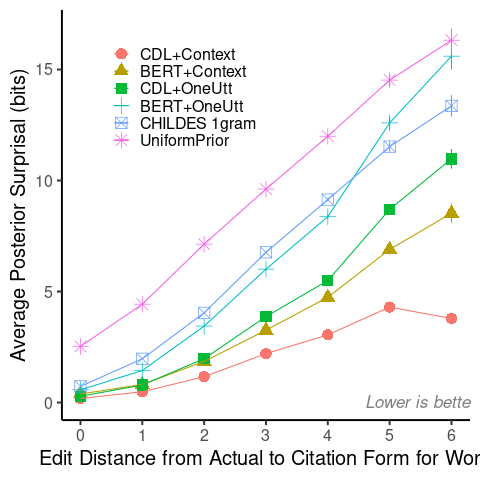

In [515]:
%%R

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model_shortname, shape=model_shortname), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model_shortname), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model_shortname, 
shape=model_shortname)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6))

ggsave('figures/surpsisal_by_edit_distance_likelihoods.pdf', height=6, width=8)    
print(p1)

In [376]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'WFST')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"
unigram_prior

surprisal_by_edit_distance_wfst = merge(subset(surprisal_by_edit_distance, likelihood_type == 'WFST'), unigram_prior)
surprisal_by_edit_distance_wfst$multiplier = 2^( surprisal_by_edit_distance_wfst$unigram_prior_prob -
    surprisal_by_edit_distance_wfst$mean_posterior_surprisal)

head(surprisal_by_edit_distance_wfst, n=10)



   edit_distance            model likelihood_type mean_posterior_surprisal
1              0     BERT+Context            WFST                0.3872064
2              0      BERT+OneUtt            WFST                0.5758648
3              0 CDL+Context+Tags            WFST                0.1835117
4              0  CDL+OneUtt+Tags            WFST                0.2857281
5              0    CHILDES 1gram            WFST                0.7275433
6              0     UniformPrior            WFST                2.5290687
7              1     BERT+Context            WFST                0.8159963
8              1      BERT+OneUtt            WFST                1.4440072
9              1 CDL+Context+Tags            WFST                0.4878638
10             1  CDL+OneUtt+Tags            WFST                0.7902474
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.004045467 0.3872064 0.3872064           2.529069
2                   0.004761063 0

In [377]:
%%R
subset(surprisal_by_edit_distance_wfst, edit_distance == 6)

   edit_distance            model likelihood_type mean_posterior_surprisal
37             6     BERT+Context            WFST                 8.528983
38             6      BERT+OneUtt            WFST                15.601043
39             6 CDL+Context+Tags            WFST                 3.784691
40             6  CDL+OneUtt+Tags            WFST                10.974689
41             6    CHILDES 1gram            WFST                13.361819
42             6     UniformPrior            WFST                16.318242
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
37                    0.4403265  8.528983  8.528983           16.31824
38                    0.6005674 15.601043 15.601043           16.31824
39                    0.2669076  3.784691  3.784691           16.31824
40                    0.4426460 10.974689 10.974689           16.31824
41                    0.4846113 13.361819 13.361819           16.31824
42                    0.5231606 16.318242 16.3182

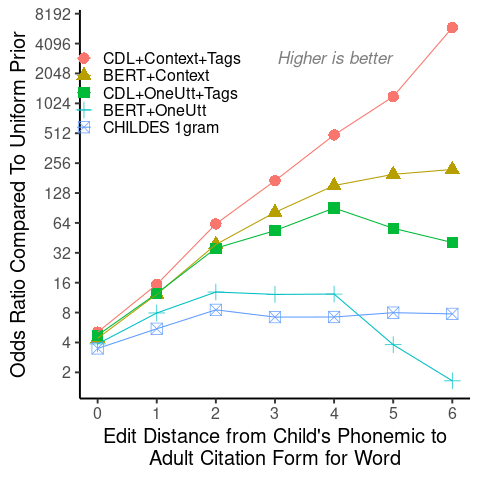

In [428]:
%%R
df_for_reordering = subset(surprisal_by_edit_distance_wfst, edit_distance <= 6 & model %in% overview_set & likelihood_type =='WFST')
df_for_reordering$model = factor(df_for_reordering$model, levels = models_for_6_plots)


p2= ggplot(subset(df_for_reordering, model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    "Edit Distance from Child's Phonemic to\nAdult Citation Form for Word") + ylab(
    'Odds Ratio Compared To Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank())  + annotate("text", label="Higher is better", 
    x=4, y=3000, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2', breaks=2^c(1:15), labels = 2^c(1:15)
) + scale_x_continuous(breaks=c(0:6), labels = c(0:6)) + scale_color_manual(
    values = colors_for_6_plots) + scale_fill_manual(values = colors_for_6_plots)
ggsave('figures/multiplier_by_edit_dstance_log_scale_all.pdf', height=6, width=8)    
print(p2)

### Proportion Agreeing with Annotator

%%R
proportion_retrieved = aggregate(prior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x < 5)})
proportion_retrieved

In [ ]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x == 0)})
proportion_retrieved

### Proportion Agreeing with Annotator Per Age

In [ ]:
%%R
names(successes_across_time)

In [ ]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

In [ ]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model)
) + geom_point(aes(x=age, y=posterior_rank, color=model, shape=model)) + coord_cartesian(ylim=c(0,1)) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank())




# Discussion: Child-Specific Analyses

In [305]:
from utils import load_splits
all_tokens_phono = load_splits.load_phono()
all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

In [310]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

In [311]:
%%R
names(successes_across_time_with_child_label)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "target_child_name"    


In [313]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)
subset(posterior_entropy_by_child, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name posterior_entropy
17  CDL+Context+Tags            WFST              Alex         0.4836744
49  CDL+Context+Tags            WFST             Ethan         0.5932303
81  CDL+Context+Tags            WFST              Lily         0.2841138
113 CDL+Context+Tags            WFST             Naima         0.3599799
145 CDL+Context+Tags            WFST            Violet         0.3900503
177 CDL+Context+Tags            WFST           William         0.4690460


In [332]:
%%R
proportion_retrieved = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name prior_probability
17  CDL+Context+Tags            WFST              Alex          3.986931
49  CDL+Context+Tags            WFST             Ethan          3.334049
81  CDL+Context+Tags            WFST              Lily          3.007195
113 CDL+Context+Tags            WFST             Naima          3.210395
145 CDL+Context+Tags            WFST            Violet          3.204872
177 CDL+Context+Tags            WFST           William          3.431928


In [318]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')


               model likelihood_type target_child_name proportion_top_1
17  CDL+Context+Tags            WFST              Alex        0.8706831
49  CDL+Context+Tags            WFST             Ethan        0.8240000
81  CDL+Context+Tags            WFST              Lily        0.9293123
113 CDL+Context+Tags            WFST             Naima        0.9018465
145 CDL+Context+Tags            WFST            Violet        0.8951975
177 CDL+Context+Tags            WFST           William        0.8750221


In [321]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')



               model likelihood_type target_child_name proportion_top_1
17  CDL+Context+Tags            WFST              Alex        0.4775649
49  CDL+Context+Tags            WFST             Ethan        0.5824516
81  CDL+Context+Tags            WFST              Lily        0.5686275
113 CDL+Context+Tags            WFST             Naima        0.5815112
145 CDL+Context+Tags            WFST            Violet        0.5583156
177 CDL+Context+Tags            WFST           William        0.5418658
